### Libs import

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Data reading

In [219]:
data1 = pd.read_csv('data/data1.csv', index_col='DateTime')
data2 = pd.read_csv('data/data2.csv', index_col='DateTime')

### Data cleaning

In [220]:
# data1 = data1[(data1['ro1'] >= 1.0) & (data1['ro1'] <= 2.5) & \
#         (data1['ro2'] >= 1.0) & (data1['ro2'] <= 2.5) & \
#         (data1['ro3'] >= 1.0) & (data1['ro3'] <= 2.5) & \
#         (data1['ro4'] >= 1.0) & (data1['ro4'] <= 2.5)]
# data2 = data2[(data2['ro1'] >= 1.0) & (data2['ro1'] <= 2.5) & \
#         (data2['ro2'] >= 1.0) & (data2['ro2'] <= 2.5) & \
#         (data2['ro3'] >= 1.0) & (data2['ro3'] <= 2.5) & \
#         (data2['ro4'] >= 1.0) & (data2['ro4'] <= 2.5)]

data1.index = pd.to_datetime(data1.index)
data2.index = pd.to_datetime(data2.index)

In [221]:
data1.isna().sum().sum()

0

In [222]:
data1.describe()

,Ni1,S1,Fe3O41,Ni2,S2,Fe3O42,Ni3,S3,Fe3O43,Ni4,...,ro2,ro3,ro4,ro_final,ust1,ust2,ust3,ust4,v_final,level_final
count,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,...,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000
mean,5.477315,20.003626,1.951034,5.731805,17.743569,2.520591,7.547059,19.185887,2.681726,8.906555,...,1.699458,1.720863,1.873061,1.663788,17.495724,22.265632,27.880240,128.550099,134.460871,49.213927
std,1.174854,2.604641,0.765599,1.808937,3.004234,1.295176,1.334541,3.780063,1.232703,0.454001,...,0.478319,0.375284,0.384344,0.350396,14.590002,20.538308,20.696594,23.069860,83.669148,28.835602
min,3.660000,9.930000,0.200000,2.870000,7.970000,0.200000,4.130000,6.680000,0.300000,4.540000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.000000,0.000000,-1.000000
25%,4.690000,19.240000,1.500000,4.260000,16.460000,1.600000,6.480000,16.500000,2.100000,8.670000,...,1.227700,1.605000,1.749125,1.444900,0.000000,10.000000,10.000000,113.000000,9.000000,40.073300
50%,5.110000,20.400000,1.800000,5.110000,18.600000,2.000000,7.430000,18.800000,2.600000,8.900000,...,1.798000,1.791300,1.907450,1.841800,17.000000,14.000000,28.000000,125.000000,167.000000,56.605600
75%,5.950000,21.400000,2.200000,7.220000,19.600000,2.900000,8.450000,21.900000,3.500000,9.140000,...,2.038350,1.921450,2.127750,1.903700,26.000000,35.000000,44.000000,142.000000,191.000000,71.379700
max,9.600000,27.720000,6.200000,10.240000,29.540000,7.900000,10.890000,38.300000,8.700000,10.440000,...,2.997900,2.998100,2.995700,2.999800,81.000000,96.000000,96.000000,215.000000,285.000000,100.000000


In [223]:
data1.isnull().sum()

Ni1            0
S1             0
Fe3O41         0
Ni2            0
S2             0
Fe3O42         0
Ni3            0
S3             0
Fe3O43         0
Ni4            0
S4             0
Fe3O44         0
Ni_final       0
S_final        0
Fe3O4_final    0
ro1            0
ro2            0
ro3            0
ro4            0
ro_final       0
ust1           0
ust2           0
ust3           0
ust4           0
v_final        0
level_final    0
dtype: int64

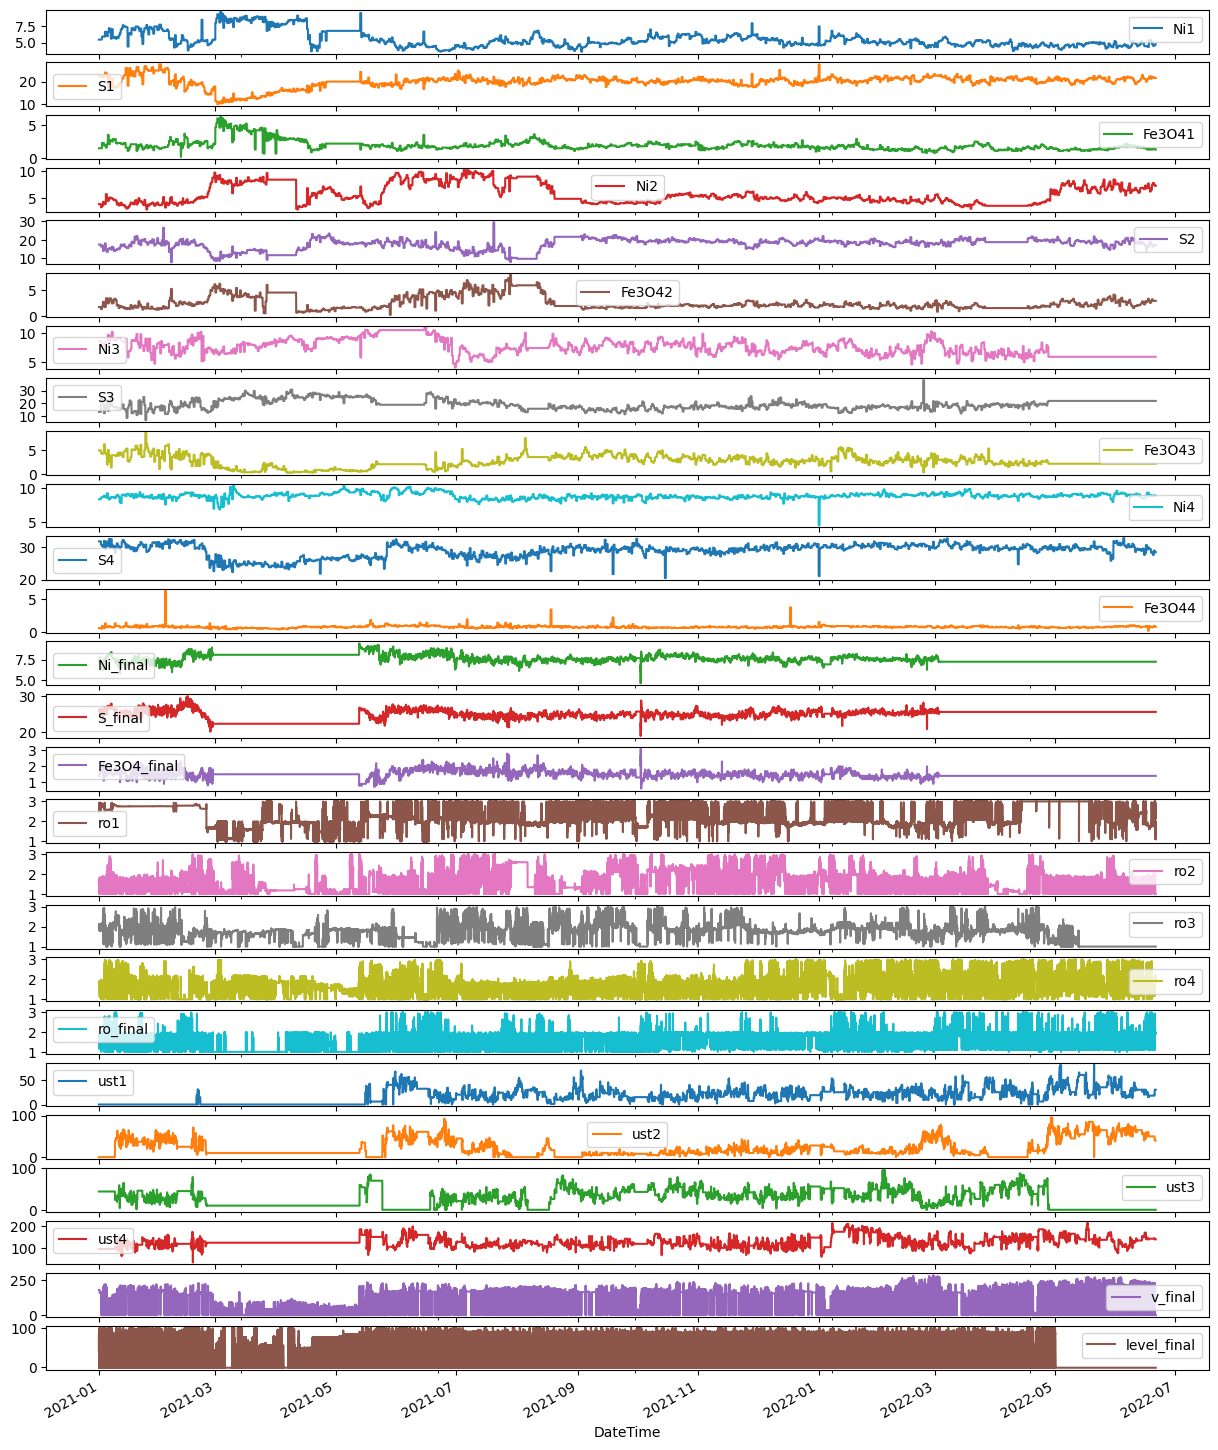

In [224]:
data1.plot(subplots=True, figsize=(15, 20))
plt.show()

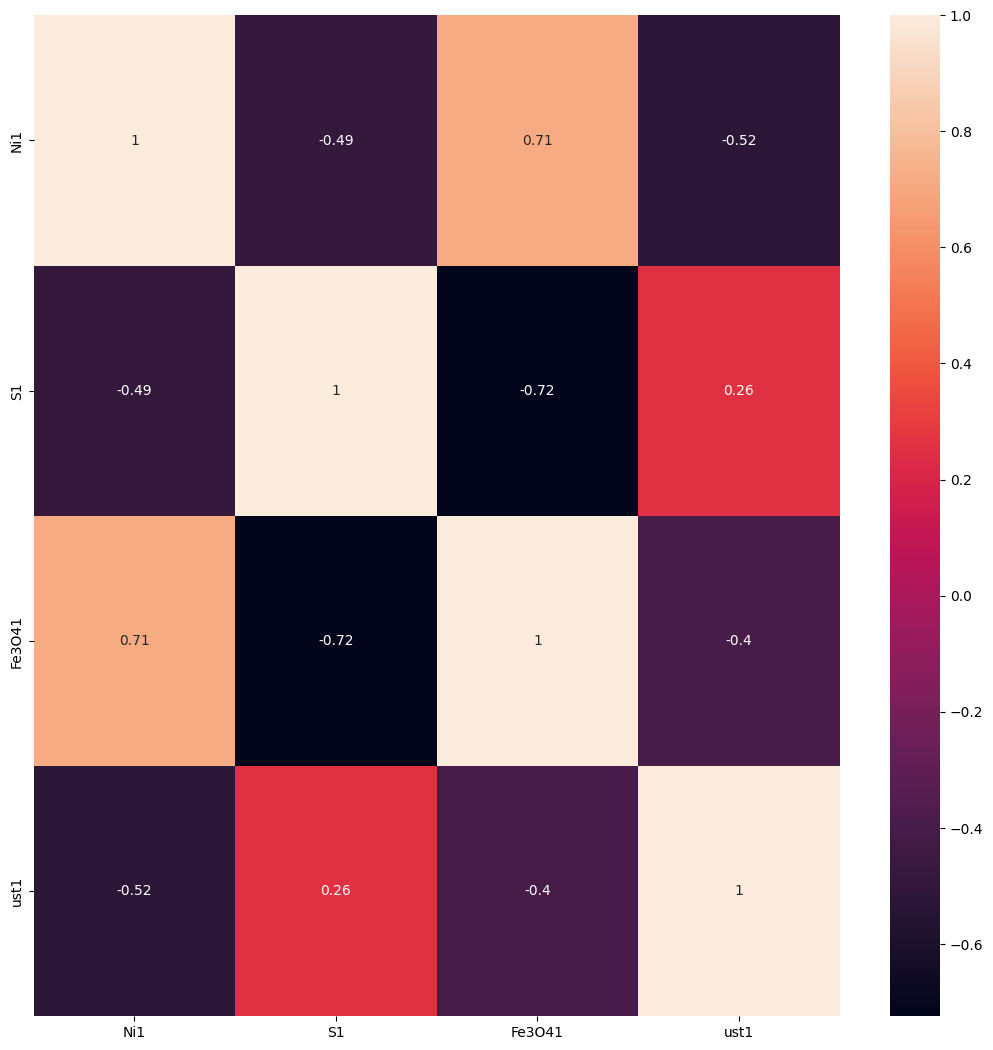

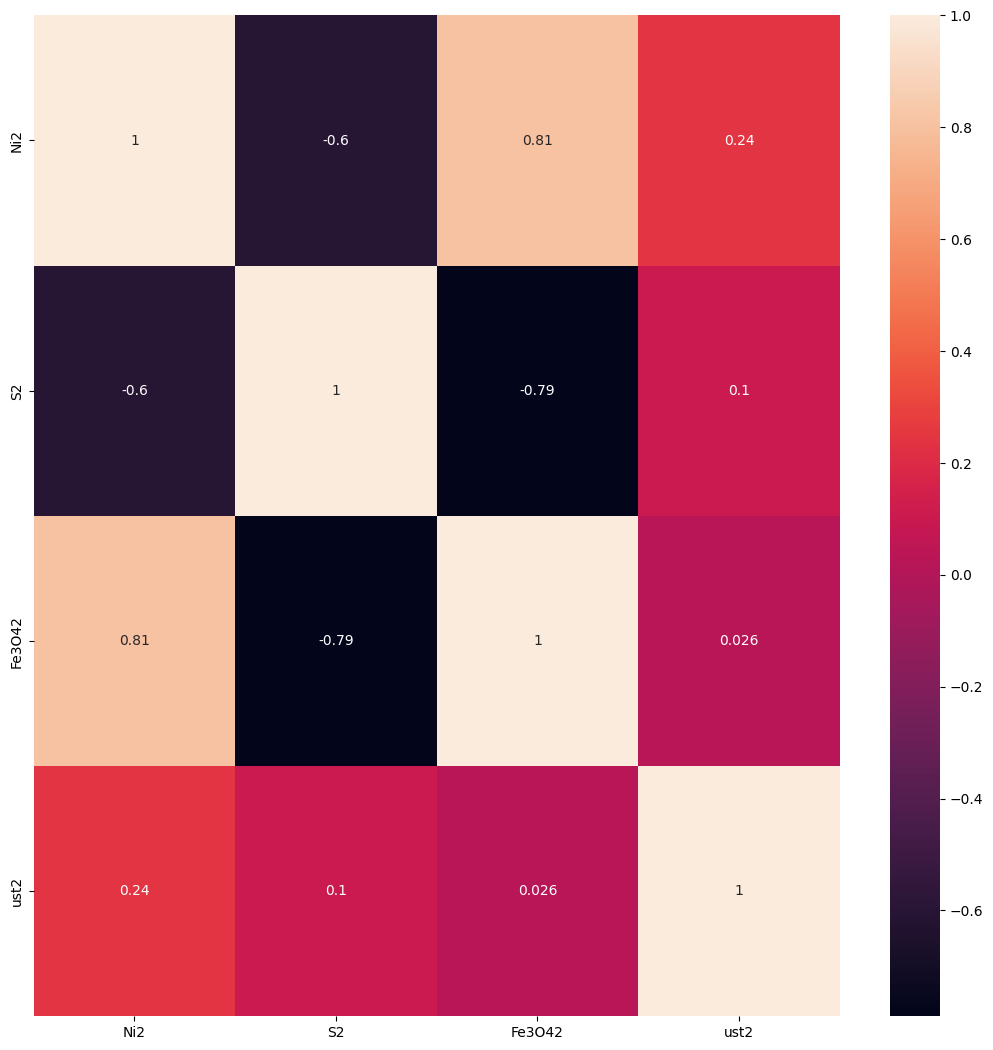

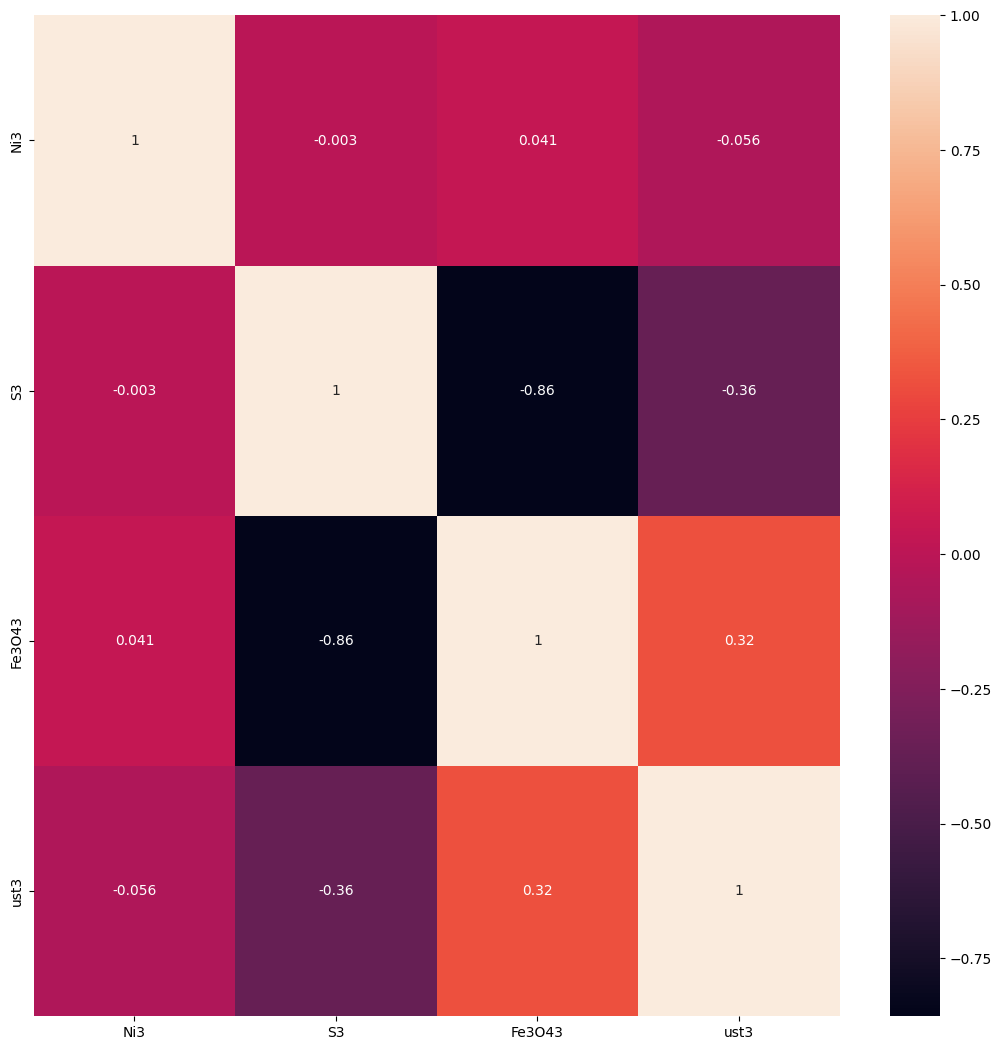

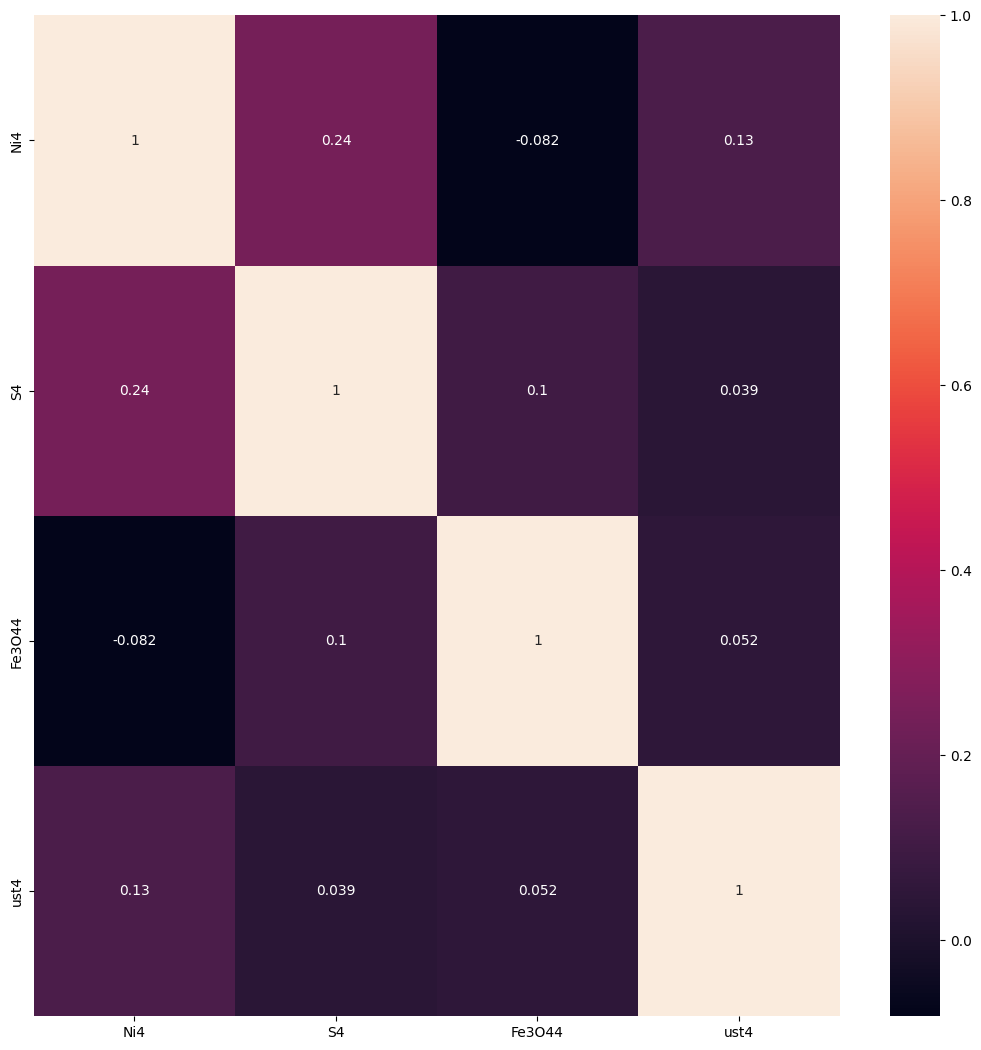

In [225]:
for i in range(1, 5):
  plt.figure(figsize=(13,13))
  sns.heatmap(data1[[f'Ni{i}', f'S{i}', f'Fe3O4{i}', f'ust{i}']].corr(), annot=True)
  plt.show()

### physical and mathematical description

$$C_{final,i}=\frac{\sum_{j=1}^{4}(F_j*C_{i,j})}{\sum_{j=1}^{4}F_j}$$
где $C_{final,i}$ - концентрация $i$-го вещества на выходе,  
$F_j$ - поток из $j$-ой емкости (определяемый уставкой $ust_j$),  
$C_{i,j}$ - концентрация $i$-го вещества в $j$-ой емкости

Уравнения для Никеля, Серы и Fe304:
$$Ni_{final}=\frac{F_1*Ni_1 + F_2*Ni_2 + F_3*Ni_3 + F_4*Ni_4}{F_1+F_2+F_3+F_4}$$  
$$S_{final}=\frac{F_1*S_1 + F_2*S_2 + F_3*S_3 + F_4*S_4}{F_1+F_2+F_3+F_4}$$
$$Fe304_{final}=\frac{F_1*Fe304_1 + F_2*Fe304_2 + F_3*Fe304_3 + F_4*Fe304_4}{F_1+F_2+F_3+F_4}$$

Уравнение для плотности смеси:
$$\rho_{final}=\frac{\sum_{j=1}^{4}(F_j*\rho_j)}{\sum_{j=1}^{4}F_j}$$  
где $\rho_{final}$ - плоность смеси на выходе,  
$\rho_j$ - плотность вещества в j-ой емкости

Уравнение объема смеси в баке:
$$\nu_{final}=\sum_{j=1}^{4}F_j$$  
  
Уровень заполненности бака:
$$level_{final}=\frac{\nu_{final}}{A}$$

Каждый регулятор будет управлять уставкой потока $F_j$ на основе отклонения выходной концентрации от целевого значения:
$$F_j{t} = K_p * e(t) + K_i * \int (e(t)dt + K_d) \frac{de(t)}{dt}$$  
  
$e(t) = C_{traget, i} - C_{final,i}(t)$ - отклонение от целевого значения  
$K_p, K_i, K_d$ - коэффициенты регулятора

Оптимизация целевой фукнции:

$$J=\sum_{t=1}^{T}[\sum_{i=1}^{3}(C_{target, i}-C_{final, i}(t))^2 + (\rho_{target, i}-\rho_{final, i}(t))^2]$$

<Axes: >

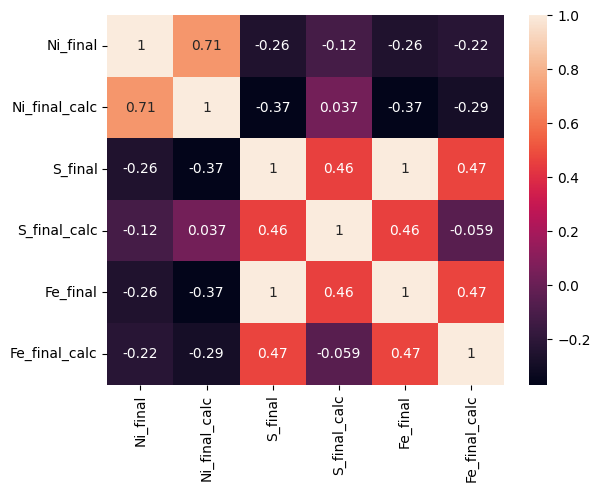

In [226]:
pred_ni = pd.concat([
  data1['Ni_final'],
  (data1['ust1'] * data1['Ni1'] + data1['ust2'] * data1['Ni2'] + \
  data1['ust3'] * data1['Ni3'] + data1['ust4'] * data1['Ni4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_ni.columns = ['Ni_final', 'Ni_final_calc']

pred_S = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['S1'] + data1['ust2'] * data1['S2'] + \
  data1['ust3'] * data1['S3'] + data1['ust4'] * data1['S4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_S.columns = ['S_final', 'S_final_calc']

pred_Fe = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['Fe3O41'] + data1['ust2'] * data1['Fe3O42'] + \
  data1['ust3'] * data1['Fe3O43'] + data1['ust4'] * data1['Fe3O44']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_Fe.columns = ['Fe_final', 'Fe_final_calc']

sns.heatmap(
  pd.concat([
    pred_ni,
    pred_S,
    pred_Fe,
  ], axis=1).corr(),
  annot=True
)

<Axes: xlabel='DateTime'>

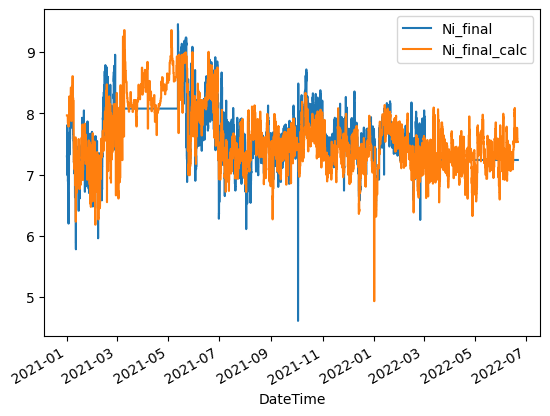

In [227]:
X = pred_ni['Ni_final_calc'].values.reshape(-1, 1)
y = pred_ni['Ni_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_ni.iloc[:, 0], pred_ni.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

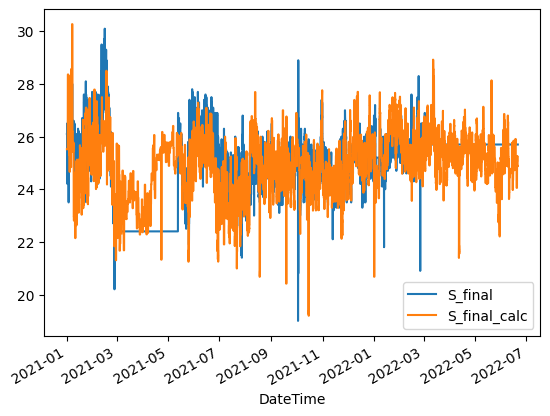

In [228]:
X = pred_S['S_final_calc'].values.reshape(-1, 1)
y = pred_S['S_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_S.iloc[:, 0], pred_S.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

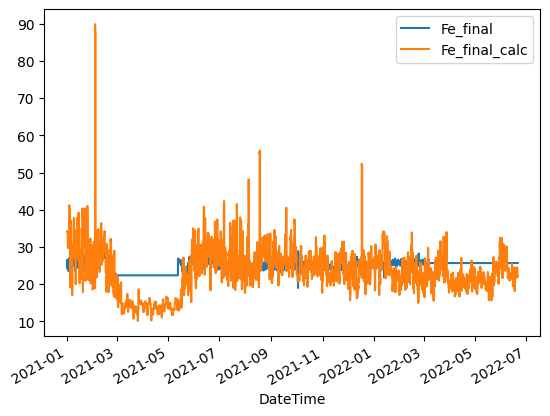

In [229]:
X = pred_Fe['Fe_final_calc'].values.reshape(-1, 1)
y = pred_Fe['Fe_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_Fe.iloc[:, 0], pred_Fe.iloc[:, 1] * lr.coef_[0]], axis=1).plot()